<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Binaria_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


## Funções

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Segmentado/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
           
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação



*   Batch size = 32
*   Image size = 120x120



## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado2/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado2/Validation'

In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [18]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 5675 images belonging to 2 classes.
Found 1509 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [12]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 0.00%, AUC: 56.66%, Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [20]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 56s - loss: 0.7321 - acc: 0.5677 - val_loss: 0.6729 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 0.67294, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 2/50
 - 55s - loss: 0.6878 - acc: 0.6146 - val_loss: 0.6478 - val_acc: 0.6562

Epoch 00002: val_loss improved from 0.67294 to 0.64778, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 3/50
 - 56s - loss: 0.6613 - acc: 0.6510 - val_loss: 0.7264 - val_acc: 0.5938

Epoch 00003: val_loss did not improve from 0.64778
Epoch 4/50
 - 52s - loss: 0.6741 - acc: 0.6198 - val_loss: 0.6301 - val_acc: 0.6875

Epoch 00004: val_loss improved from 0.64778 to 0.63008, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 5/50
 - 52s - loss: 0.6542 - acc: 0.6667 - val_loss: 0.7183 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.63008
Epoch 6/50
 - 53s - loss: 0.6560 - acc: 0.6510 - val_loss: 0.6639 - v

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

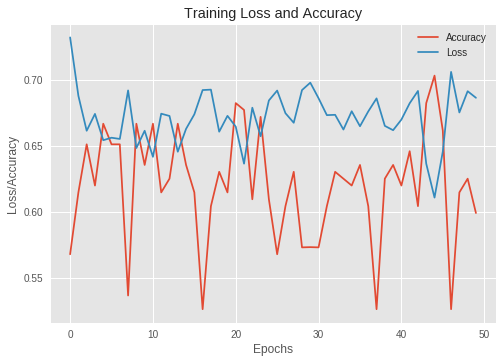

In [22]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [27]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 56.66%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


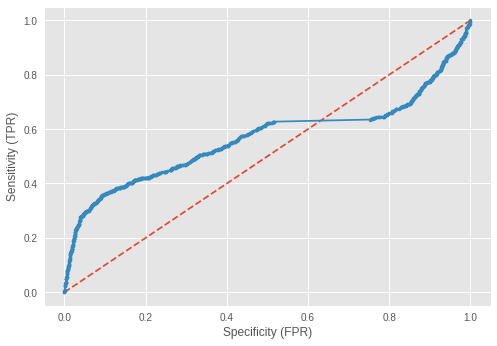

In [29]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa  - Test Precision: 0.00%, AUC: 65.61%, Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [34]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6860 - acc: 0.6823 - val_loss: 0.6838 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.68383, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6888 - acc: 0.5781 - val_loss: 0.6873 - val_acc: 0.5938

Epoch 00002: val_loss did not improve from 0.68383
Epoch 3/50
 - 1s - loss: 0.6751 - acc: 0.6615 - val_loss: 0.6603 - val_acc: 0.7812

Epoch 00003: val_loss improved from 0.68383 to 0.66027, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6702 - acc: 0.6406 - val_loss: 0.6730 - val_acc: 0.6406

Epoch 00004: val_loss did not improve from 0.66027
Epoch 5/50
 - 1s - loss: 0.6449 - acc: 0.7031 - val_loss: 0.6608 - val_acc: 0.6562

Epoch 00005: val_loss did not improve from 0.66027
Epoch 6/50
 - 1s - loss: 0.6670 - acc: 0.6198 - val_loss: 0.6446 - val_acc: 0.7188

Epoch 00006: val_loss improved from 0.66027 to 0.64463, saving model to dri

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

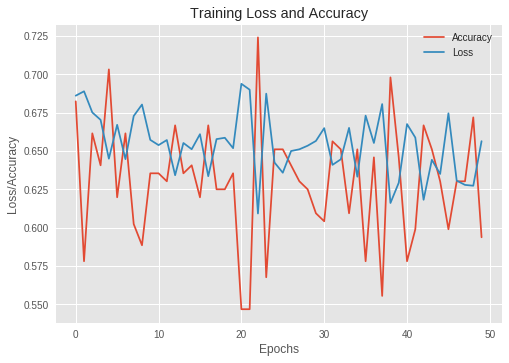

In [36]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [37]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [38]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 65.61%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


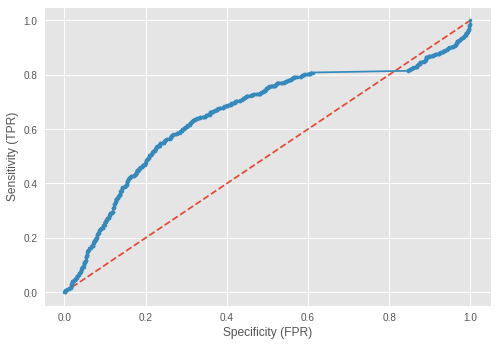

In [39]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 33.33%, AUC: 58.49%, Accuracy: 80.33%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [44]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 3.3660 - acc: 0.5417 - val_loss: 2.7115 - val_acc: 0.5859

Epoch 00001: val_loss improved from inf to 2.71150, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 2.6165 - acc: 0.6068 - val_loss: 0.8438 - val_acc: 0.4609

Epoch 00002: val_loss improved from 2.71150 to 0.84383, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 3/50
 - 1s - loss: 1.6654 - acc: 0.5443 - val_loss: 1.3033 - val_acc: 0.4453

Epoch 00003: val_loss did not improve from 0.84383
Epoch 4/50
 - 1s - loss: 0.9587 - acc: 0.6276 - val_loss: 0.9719 - val_acc: 0.4219

Epoch 00004: val_loss did not improve from 0.84383
Epoch 5/50
 - 1s - loss: 1.1208 - acc: 0.6380 - val_loss: 0.9457 - val_acc: 0.3672

Epoch 00005: val_loss did not improve from 0.84383
Epoch 6/50
 - 1s - loss: 0.7749 - acc: 0.6615 - val_loss: 1.2006 - val_acc: 0.3438

Epoch 00006: val_loss did not improve from 0.84383
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

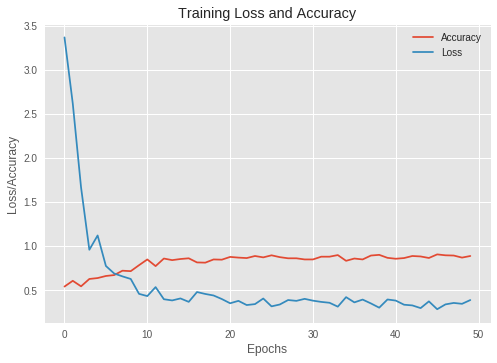

In [46]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [47]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [48]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 33.33%, AUC: 58.49%, Accuracy: 80.33%


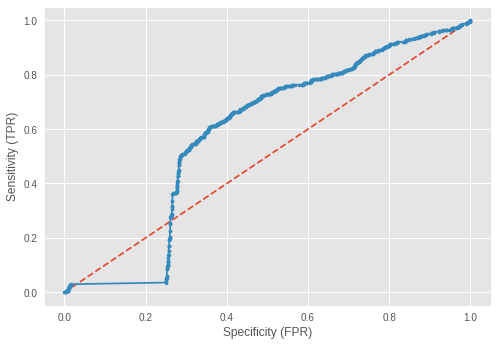

In [49]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 0.00%, AUC: 94.50%, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [54]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.6265 - acc: 0.6875 - val_loss: 0.6297 - val_acc: 0.7344

Epoch 00001: val_loss improved from inf to 0.62972, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.4657 - acc: 0.8255 - val_loss: 0.7256 - val_acc: 0.7297

Epoch 00002: val_loss did not improve from 0.62972
Epoch 3/50
 - 1s - loss: 0.3808 - acc: 0.8906 - val_loss: 1.1060 - val_acc: 0.5781

Epoch 00003: val_loss did not improve from 0.62972
Epoch 4/50
 - 1s - loss: 0.3194 - acc: 0.9062 - val_loss: 0.9460 - val_acc: 0.7266

Epoch 00004: val_loss did not improve from 0.62972
Epoch 5/50
 - 1s - loss: 0.3466 - acc: 0.8984 - val_loss: 0.8315 - val_acc: 0.7344

Epoch 00005: val_loss did not improve from 0.62972
Epoch 6/50
 - 1s - loss: 0.3249 - acc: 0.8828 - val_loss: 0.8598 - val_acc: 0.7188

Epoch 00006: val_loss did not improve from 0.62972
Epoch 7/50
 - 1s - loss: 0.3249 - acc: 0.8880 - val_loss: 1.4116 - val_acc: 0.6250

Epoch 00007: val_loss did

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

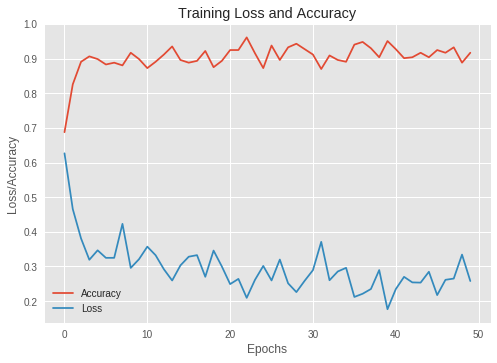

In [56]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [57]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [58]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 94.50%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


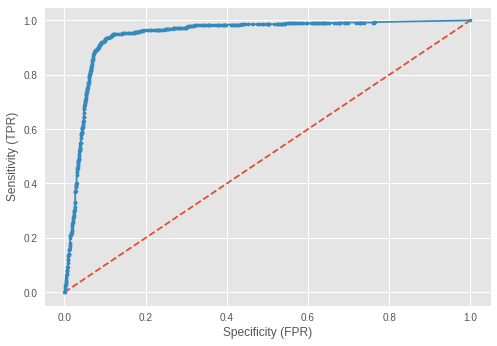

In [59]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 25.00%, AUC: 71.61%, Accuracy: 80.30%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [64]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 2.5299 - acc: 0.5938 - val_loss: 0.9141 - val_acc: 0.5781

Epoch 00001: val_loss improved from inf to 0.91406, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 2.0177 - acc: 0.5833 - val_loss: 0.9641 - val_acc: 0.5938

Epoch 00002: val_loss did not improve from 0.91406
Epoch 3/50
 - 1s - loss: 1.1615 - acc: 0.6068 - val_loss: 0.6600 - val_acc: 0.6797

Epoch 00003: val_loss improved from 0.91406 to 0.66003, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 4/50
 - 1s - loss: 1.0729 - acc: 0.5944 - val_loss: 0.7377 - val_acc: 0.5781

Epoch 00004: val_loss did not improve from 0.66003
Epoch 5/50
 - 1s - loss: 0.8464 - acc: 0.6146 - val_loss: 0.9362 - val_acc: 0.3750

Epoch 00005: val_loss did not improve from 0.66003
Epoch 6/50
 - 1s - loss: 0.8781 - acc: 0.5964 - val_loss: 0.5782 - val_acc: 0.7891

Epoch 00006: val_loss improved from 0.66003 to 0.57818, saving model to dri

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

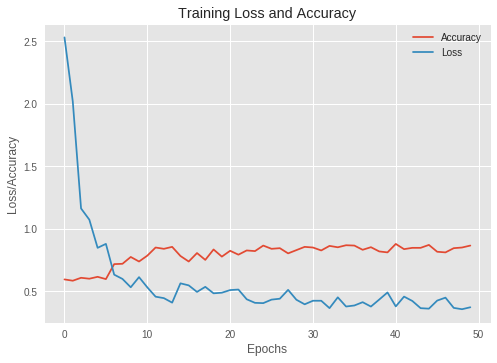

In [66]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [67]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [68]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 25.00%, AUC: 71.61%, Accuracy: 80.30%


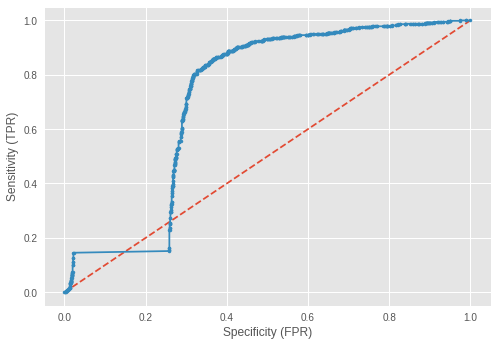

In [69]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 0.00%, AUC: 17.93%, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [74]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.6144 - acc: 0.6823 - val_loss: 0.7266 - val_acc: 0.6328

Epoch 00001: val_loss improved from inf to 0.72661, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 2/50
 - 1s - loss: 0.4332 - acc: 0.8542 - val_loss: 0.7351 - val_acc: 0.6172

Epoch 00002: val_loss did not improve from 0.72661
Epoch 3/50
 - 1s - loss: 0.4057 - acc: 0.8698 - val_loss: 0.6630 - val_acc: 0.8047

Epoch 00003: val_loss improved from 0.72661 to 0.66303, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 4/50
 - 1s - loss: 0.4769 - acc: 0.8307 - val_loss: 0.6081 - val_acc: 0.7578

Epoch 00004: val_loss improved from 0.66303 to 0.60805, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 5/50
 - 1s - loss: 0.4154 - acc: 0.8854 - val_loss: 0.3559 - val_acc: 0.8906

Epoch 00005: val_loss improved from 0.60805 to 0.35591, saving model to drive/My Drive/Resultado/Segmentado/weights_architect

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

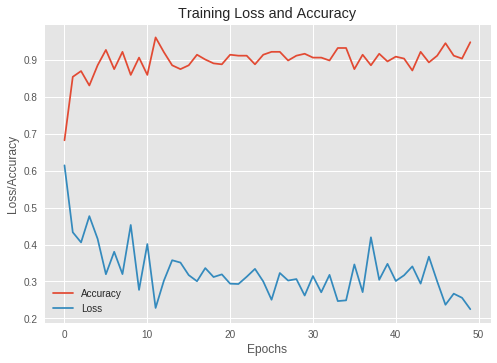

In [76]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [77]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [78]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 17.93%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


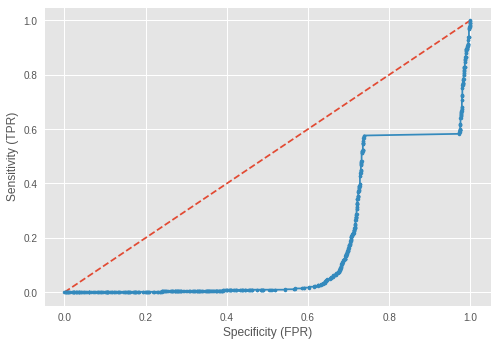

In [79]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 53.16%, AUC: 86.78%, Accuracy: 80.51%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [84]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.5841 - acc: 0.7057 - val_loss: 0.7442 - val_acc: 0.7266

Epoch 00001: val_loss improved from inf to 0.74416, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.4897 - acc: 0.8047 - val_loss: 0.9782 - val_acc: 0.6328

Epoch 00002: val_loss did not improve from 0.74416
Epoch 3/50
 - 1s - loss: 0.4857 - acc: 0.8021 - val_loss: 1.8153 - val_acc: 0.6406

Epoch 00003: val_loss did not improve from 0.74416
Epoch 4/50
 - 1s - loss: 0.3448 - acc: 0.8854 - val_loss: 1.1859 - val_acc: 0.6875

Epoch 00004: val_loss did not improve from 0.74416
Epoch 5/50
 - 1s - loss: 0.3415 - acc: 0.8932 - val_loss: 1.0725 - val_acc: 0.6486

Epoch 00005: val_loss did not improve from 0.74416
Epoch 6/50
 - 1s - loss: 0.3782 - acc: 0.8646 - val_loss: 0.7161 - val_acc: 0.7344

Epoch 00006: val_loss improved from 0.74416 to 0.71609, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

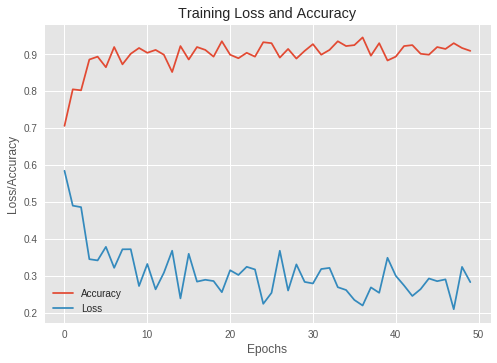

In [86]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [87]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [88]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 53.16%, AUC: 86.78%, Accuracy: 80.51%


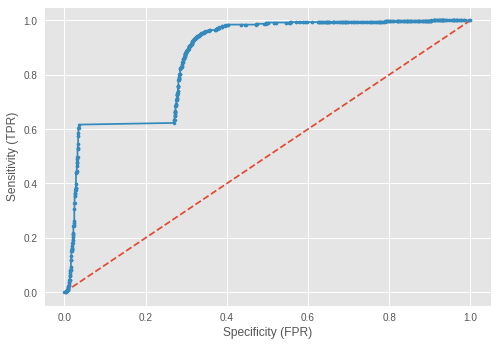

In [89]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa - Test Precision: 10.00%, AUC: 65.66%, Accuracy: 80.12%

Modelo adaptado do **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [94]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 2.7617 - acc: 0.4922 - val_loss: 1.6658 - val_acc: 0.5391

Epoch 00001: val_loss improved from inf to 1.66583, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 1.6817 - acc: 0.5574 - val_loss: 0.6437 - val_acc: 0.6562

Epoch 00002: val_loss improved from 1.66583 to 0.64375, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 3/50
 - 1s - loss: 1.1512 - acc: 0.5938 - val_loss: 0.7723 - val_acc: 0.6094

Epoch 00003: val_loss did not improve from 0.64375
Epoch 4/50
 - 1s - loss: 0.9653 - acc: 0.6328 - val_loss: 0.6739 - val_acc: 0.6719

Epoch 00004: val_loss did not improve from 0.64375
Epoch 5/50
 - 1s - loss: 0.7287 - acc: 0.6719 - val_loss: 0.5221 - val_acc: 0.7891

Epoch 00005: val_loss improved from 0.64375 to 0.52206, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 6/50
 - 1s - loss: 0.6665 - acc: 0.7474 - val_loss: 0.5241 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

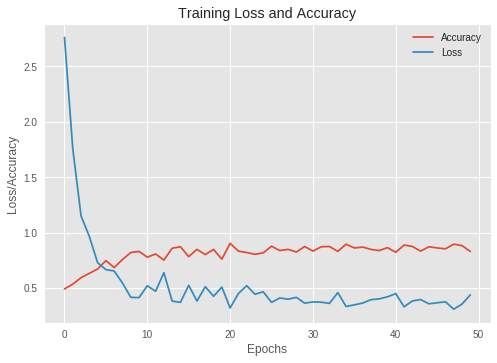

In [96]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [97]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [98]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 10.00%, AUC: 65.66%, Accuracy: 80.12%


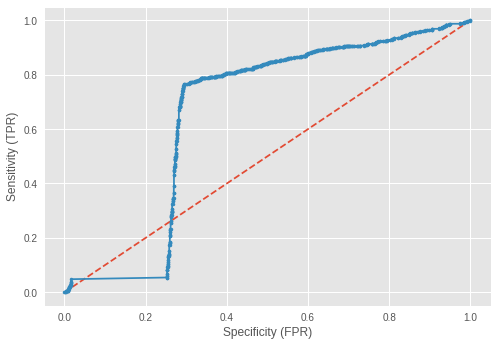

In [99]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 53.47%, AUC: 91.25%, Accuracy: 80.57%

Modelo adaptado do**Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [104]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 6.1419 - acc: 0.4583 - val_loss: 5.1393 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 5.13927, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 3.9492 - acc: 0.5521 - val_loss: 1.2187 - val_acc: 0.6250

Epoch 00002: val_loss improved from 5.13927 to 1.21872, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 3/50
 - 1s - loss: 1.0800 - acc: 0.5443 - val_loss: 0.7257 - val_acc: 0.5312

Epoch 00003: val_loss improved from 1.21872 to 0.72573, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 4/50
 - 1s - loss: 0.7800 - acc: 0.6042 - val_loss: 0.7099 - val_acc: 0.5547

Epoch 00004: val_loss improved from 0.72573 to 0.70992, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 5/50
 - 1s - loss: 0.7041 - acc: 0.5781 - val_loss: 0.7047 - val_acc: 0.6406

Epoch 00005: val_loss improved from 0.70

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

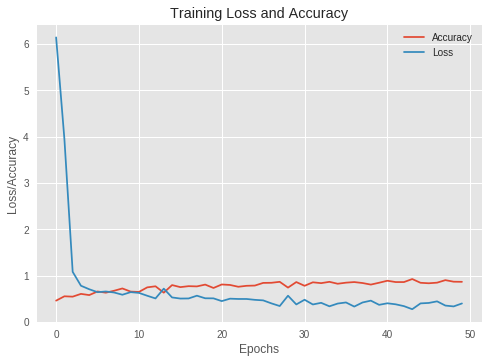

In [106]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [107]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [108]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 53.47%, AUC: 91.25%, Accuracy: 80.57%


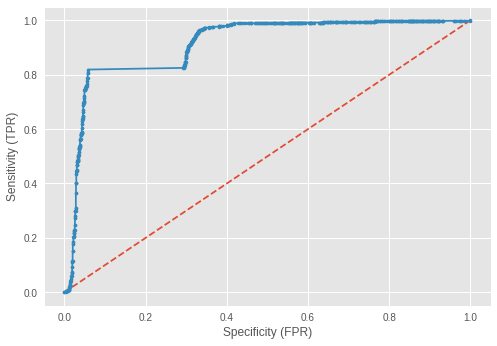

In [109]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 0.00%, AUC: 10.23%, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [114]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.9529 - acc: 0.5625 - val_loss: 0.6660 - val_acc: 0.6641

Epoch 00001: val_loss improved from inf to 0.66605, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.3065 - acc: 0.6120 - val_loss: 0.8092 - val_acc: 0.5234

Epoch 00002: val_loss did not improve from 0.66605
Epoch 3/50
 - 1s - loss: 1.1935 - acc: 0.5651 - val_loss: 0.7805 - val_acc: 0.5859

Epoch 00003: val_loss did not improve from 0.66605
Epoch 4/50
 - 1s - loss: 0.8989 - acc: 0.6406 - val_loss: 0.6092 - val_acc: 0.6719

Epoch 00004: val_loss improved from 0.66605 to 0.60924, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 5/50
 - 1s - loss: 0.8077 - acc: 0.6641 - val_loss: 0.5815 - val_acc: 0.7500

Epoch 00005: val_loss improved from 0.60924 to 0.58146, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 6/50
 - 1s - loss: 0.7614 - acc: 0.6432 - val_loss: 0.7009 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

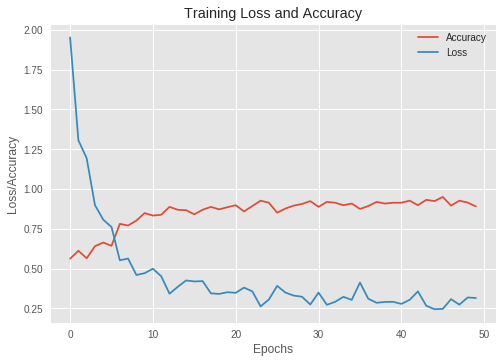

In [116]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [117]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [118]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 10.23%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


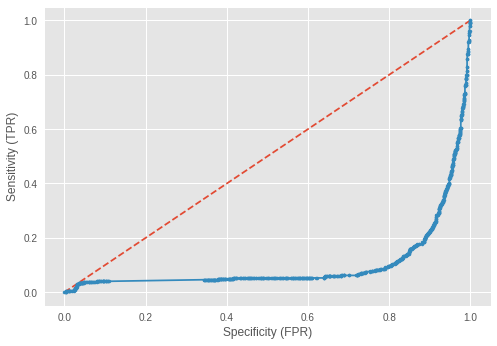

In [119]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 0.00%, AUC: 58.45%, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [124]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 2.0503 - acc: 0.5469 - val_loss: 0.7365 - val_acc: 0.5405

Epoch 00001: val_loss improved from inf to 0.73651, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 1.2887 - acc: 0.5781 - val_loss: 0.6765 - val_acc: 0.6875

Epoch 00002: val_loss improved from 0.73651 to 0.67652, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 1.2251 - acc: 0.5260 - val_loss: 0.7569 - val_acc: 0.6172

Epoch 00003: val_loss did not improve from 0.67652
Epoch 4/50
 - 1s - loss: 1.0632 - acc: 0.5625 - val_loss: 0.7065 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.67652
Epoch 5/50
 - 1s - loss: 0.8465 - acc: 0.6120 - val_loss: 1.0154 - val_acc: 0.3047

Epoch 00005: val_loss did not improve from 0.67652
Epoch 6/50
 - 1s - loss: 0.8075 - acc: 0.6354 - val_loss: 0.7716 - val_acc: 0.5312

Epoch 00006: val_loss did not improve from 0.67652
Epoch 7/50
 - 1s - los

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

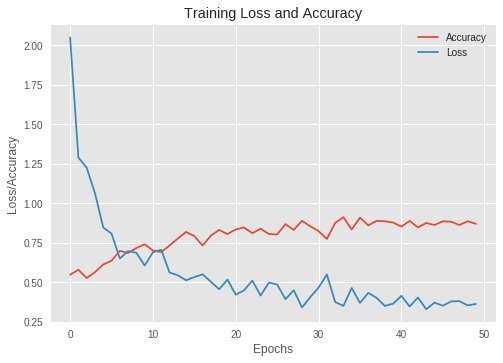

In [126]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [127]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [128]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 58.45%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


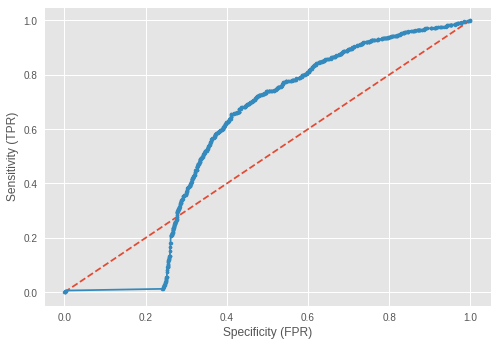

In [129]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 0.00%, AUC: 65.42%, Accuracy: 80.30%

Modelo adaptado do **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [134]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.5461 - acc: 0.5651 - val_loss: 0.6439 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 0.64388, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 1.2760 - acc: 0.5703 - val_loss: 0.8970 - val_acc: 0.5938

Epoch 00002: val_loss did not improve from 0.64388
Epoch 3/50
 - 1s - loss: 1.0822 - acc: 0.6146 - val_loss: 0.5252 - val_acc: 0.8047

Epoch 00003: val_loss improved from 0.64388 to 0.52522, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.9364 - acc: 0.6094 - val_loss: 0.6098 - val_acc: 0.6094

Epoch 00004: val_loss did not improve from 0.52522
Epoch 5/50
 - 1s - loss: 0.9236 - acc: 0.6120 - val_loss: 0.8430 - val_acc: 0.4219

Epoch 00005: val_loss did not improve from 0.52522
Epoch 6/50
 - 1s - loss: 0.7943 - acc: 0.6224 - val_loss: 0.6735 - val_acc: 0.6016

Epoch 00006: val_loss did not improve from 0.52522
Epoch 7/50
 - 1s - los

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

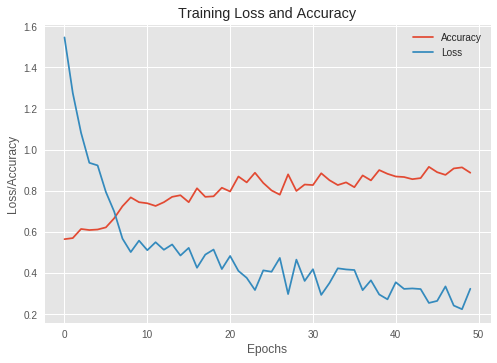

In [136]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [137]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [138]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 65.42%, Accuracy: 80.30%


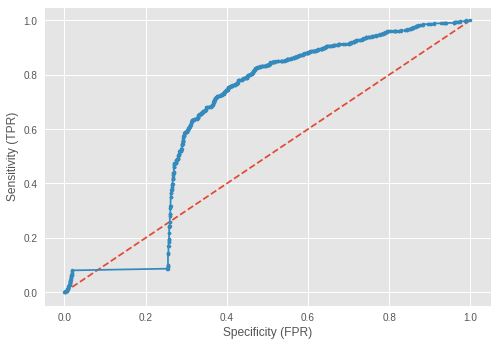

In [139]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 0.00%, AUC: 87.61%, Accuracy: 80.21%

Modelo adaptado do **Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [144]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.2668 - acc: 0.5078 - val_loss: 0.5271 - val_acc: 0.7109

Epoch 00001: val_loss improved from inf to 0.52715, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.8101 - acc: 0.6641 - val_loss: 0.5815 - val_acc: 0.7422

Epoch 00002: val_loss did not improve from 0.52715
Epoch 3/50
 - 0s - loss: 0.8296 - acc: 0.6302 - val_loss: 0.5203 - val_acc: 0.7891

Epoch 00003: val_loss improved from 0.52715 to 0.52032, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 4/50
 - 0s - loss: 0.6573 - acc: 0.6901 - val_loss: 0.2686 - val_acc: 0.9297

Epoch 00004: val_loss improved from 0.52032 to 0.26856, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 5/50
 - 1s - loss: 0.5834 - acc: 0.7422 - val_loss: 0.3694 - val_acc: 0.8203

Epoch 00005: val_loss did not improve from 0.26856
Epoch 6/50
 - 1s - loss: 0.4396 - acc: 0.8125 - val_loss: 0.4034 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

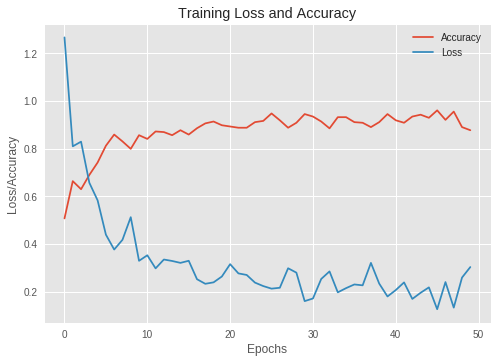

In [146]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [147]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [148]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 87.61%, Accuracy: 80.21%


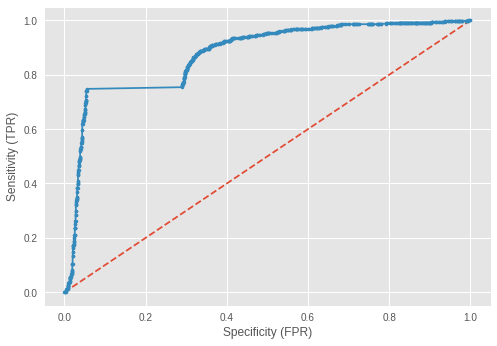

In [149]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')